In [41]:
from pathlib import Path
import json
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import random
import sys, os
import importlib

In [42]:
sys.path.append(os.path.abspath(".."))

In [43]:
import data
import models
importlib.reload(data)
from data import RangeAnnotationDataset
importlib.reload(models)
from models import AutomaticRangeNet


RangeAnnotationDataset

In [44]:
# train.py
import os
import json
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from data import RangeAnnotationDataset
from models import AutomaticRangeNet

# --- Config ---
config = {
    "data": {
        "annotations_dir": "../annotations",
        "marker_dir": "../data/tiles_marker",
        "dapi_dir": "../data/tiles_DAPI"
    },
    "train_params": {
        "batch_size": 8,
        "epochs": 50,
        "learning_rate": 1e-3,
        "val_split": 0.2,
        "shuffle": True,
        "augment": True
    },
    "log_dir": "logs"
}

# --- Dataset ---
dataset = RangeAnnotationDataset(
    annotations_dir=config["data"]["annotations_dir"],
    tiles_marker_dir=config["data"]["marker_dir"],
    tiles_dapi_dir=config["data"]["dapi_dir"],
    augment=config["train_params"]["augment"]
)

In [45]:
len(dataset)

100

In [46]:
import torch
importlib.reload(data)
from data import RangeAnnotationDataset
importlib.reload(models)
from models import AutomaticRangeNet

In [49]:
# --- Constants ---
RANGE_MIN = 0
RANGE_MAX = 1

# --- Load model ---
model = AutomaticRangeNet()
model.load_state_dict(torch.load("../checkpoints/automatic_range.pt"))
model.eval()

# --- Load some data ---
dataset = RangeAnnotationDataset(
    annotations_dir="../annotations",
    tiles_marker_dir="../data/tiles_marker",
    tiles_dapi_dir="../data/tiles_DAPI",
    augment=False
)



/tmp/ipykernel_1773276/1034087733.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../checkpoints/automatic_range.pt"))


In [50]:
N = 10
for i in range(N):
    img, target = dataset[i]
    with torch.no_grad():
        pred = model(img.unsqueeze(0))  # add batch dim

    # Denormalize predictions and targets
    pred = pred.squeeze().numpy()
    target = target.numpy()

    pred_denorm = pred * (RANGE_MAX - RANGE_MIN) + RANGE_MIN
    target_denorm = target * (RANGE_MAX - RANGE_MIN) + RANGE_MIN

    print(f"\nTile {i+1}")
    # print(f"Predicted range: {pred}")
    print(f"Predicted range: {pred_denorm}")
    print(f"Actual    range: {target_denorm}")

Loading annotation from ../annotations/MF018_early_TMA1_x4428_y120_CD4.json
Base name for tile: MF018_early_TMA1_x4428_y120
Suffix for tile: CD4
Found marker image: ../data/tiles_marker/MF018_early_TMA1_x4428_y120_CD4.tiff

Tile 1
Predicted range: [0.99605536 1.        ]
Actual    range: [0.77123207 1.        ]
Loading annotation from ../annotations/MF066_late_TMA2_x1558_y2196_CD4.json
Base name for tile: MF066_late_TMA2_x1558_y2196
Suffix for tile: CD4
Found marker image: ../data/tiles_marker/MF066_late_TMA2_x1558_y2196_CD4.tiff

Tile 2
Predicted range: [0.73758286 0.99966073]
Actual    range: [0.68436664 0.9445233 ]
Loading annotation from ../annotations/AD088_TMA1_x76_y1877_CD4.json
Base name for tile: AD088_TMA1_x76_y1877
Suffix for tile: CD4
Found marker image: ../data/tiles_marker/AD088_TMA1_x76_y1877_CD4.tiff

Tile 3
Predicted range: [0.8046282 0.9999999]
Actual    range: [0.77123207 1.        ]
Loading annotation from ../annotations/MF209_early_TMA2_x3469_y1683_CD4.json
Base na

In [54]:
import napari
import numpy as np
from skimage.io import imread
import json
import os
import torch
from models import AutomaticRangeNet

# --- Helper to load normalized image ---
def load_img(path):
    return imread(path).astype(np.float32) / 1.0  # Already normalized to [0, 1]

# --- Load model ---
model = AutomaticRangeNet()
model.load_state_dict(torch.load("../checkpoints/automatic_range.pt", map_location="cpu"))
model.eval()

/tmp/ipykernel_1773276/1121043762.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../checkpoints/automatic_range.pt", map_location="cp

AutomaticRangeNet(
  (encoder): Sequential(
    (0): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [ ]:
# --- Tiles to test ---
tile_paths = [
    "MF066_late_TMA2_x1558_y2196_CD4",
    "AD088_TMA1_x76_y1877_CD4",
    "MF209_early_TMA2_x3469_y1683_CD4"
]

annotations_dir = "../annotations"
marker_dir = "../data/tiles_marker"
dapi_dir = "../data/tiles_DAPI"

viewer = napari.Viewer()


In [60]:
for tile_name in tile_paths:
    marker_path = os.path.join(marker_dir, f"{tile_name}.tiff")

    dapi_tile_name = tile_name.replace("CD4", "DAPI")
    dapi_path = os.path.join(dapi_dir, f"{dapi_tile_name}.tiff")
    annotation_path = os.path.join(annotations_dir, f"{tile_name}.json")

    # Load images
    marker = load_img(marker_path)
    dapi = load_img(dapi_path)

    # Load true range
    with open(annotation_path) as f:
        annotation = json.load(f)
    true_min, true_max = annotation["min"], annotation["max"]

    # Predict range
    input_tensor = torch.from_numpy(np.stack([marker, dapi])[None, :, :, :]).float()
    with torch.no_grad():
        pred_min, pred_max = model(input_tensor).squeeze().tolist()

    # Add DAPI
    viewer.add_image(dapi, name=f"{tile_name} - DAPI", colormap='bop blue',contrast_limits=(0, 1))

    # Add marker (true range)
    viewer.add_image(
        marker, 
        name=f"{tile_name} - marker (true)",
        colormap='green',
        contrast_limits=(true_min, true_max),
        blending='additive'
    )

    # Add marker (predicted range)
    viewer.add_image(
        marker, 
        name=f"{tile_name} - marker (pred)",
        colormap='magenta',
        contrast_limits=(pred_min, pred_max),
        blending='additive'
    )

napari.run()

In [17]:
# Print the max of the modified image
print("Max intensity after modification:", img.max())

Max intensity after modification: 580


Median without bright spots: 0.0028898950004810084


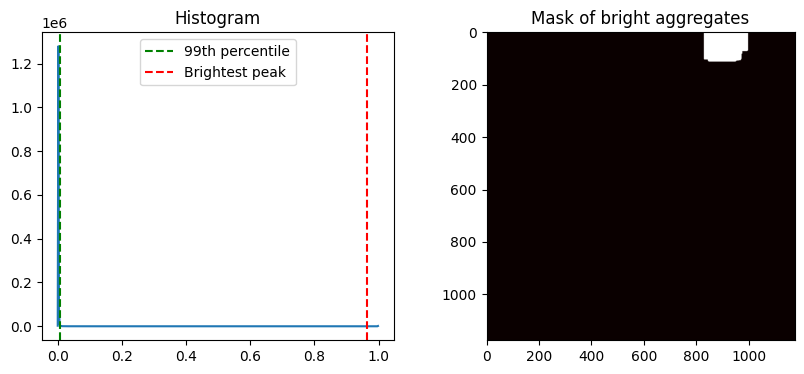

In [ ]:

# Save the mask
mask_output_path = "../data/tiles_marker/AD079_TMA1_x3893_y3878_CD4_mask.tiff"
imwrite(mask_output_path, mask.astype(np.uint8) * 255)  # Save as binary mask

In [19]:
center = (37, 913)
pointA = (55, 1013)
pointB = (77, 819)
pointC = (127, 920)

avg_distance_to_center = np.mean([
    np.linalg.norm(np.array(center) - np.array(pointA)),
    np.linalg.norm(np.array(center) - np.array(pointB)),
    np.linalg.norm(np.array(center) - np.array(pointC))
])
print("Average distance to center:", avg_distance_to_center)


Average distance to center: 98.01188014956715
